In [1]:
import os
import platform
import pandas as pd
import cv2 as cv
import json
import numpy as np
import tensorflow as tf

from tqdm import tqdm
from glob import glob, iglob
from matplotlib import image, pyplot as plt, patches

2022-05-12 03:01:45.300251: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/hadioz/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-05-12 03:01:45.300287: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
gt_train = pd.read_csv('../assets/dataset/gt_train.csv')

In [4]:
gt_train.head(10)


all data : 351548
train data : 220359
test data : 55528


,00000000,pickup_truck,213,34,255,50
0,0,car,194,78,273,122
1,0,car,155,27,183,35
2,0,articulated_truck,43,25,109,55
3,0,car,106,32,124,45
4,1,bus,205,155,568,314
5,1,bus,285,123,477,168
6,1,car,544,162,617,193
7,1,car,329,152,371,163
8,1,car,447,161,497,183
9,1,car,662,199,715,236


In [3]:
# mengumpulkan nama file yang memiliki format .jpg pada folder yang terdapat file image dataset 
name = [os.path.basename(fn) for fn in iglob("/home/hadioz/Documents/skripsi/MIO-TCD-Classification/train/background/*.jpg")]

# 

In [4]:
print(name[10])

00689891.jpg


In [5]:
filename = []
for n in name:
  fn = "{0}.jpg".format(n);
  if len(str(n)) < 8:
    fn = "{0}{1}".format("0" * (8-len(str(n))), fn)
  filename.append(fn)

filename = list(dict.fromkeys(filename))


In [6]:
filename[0]

'00604795.jpg.jpg'

In [9]:
# fungsi untuk membuka file gambar
def open_image(path, name, show = False):
    if platform.system() == 'Windows':
        idx = name.replace('/'," ").split(" ")
        name = os.path.join(idx[0], idx[1])
    
    path = os.path.join(path,name)
    img = image.imread(path)
    
    if show:
        plt.figure(figsize = (15,15))
        plt.imshow(img, interpolation='nearest')
        plt.show()
    
    return img

In [6]:
# mengumpulkan nama file yang memiliki format .jpg pada folder yang terdapat file image dataset 
name = [os.path.basename(fn) for fn in iglob("/home/hadioz/Documents/skripsi/MIO-TCD-Classification/train/background/*.jpg")]

# membuat label dataset dengan format JSON
train_data = [{"filename": n, "image-size": [], "objects" : []} for n in name]

# membuka setiap gambar yang ada pada dataset kemudian mengabil informasi ukuran gambar
for idx in tqdm(range(len(train_data))):
  img = open_image('/home/hadioz/Documents/skripsi/MIO-TCD-Classification/train/background/', train_data[idx]["filename"])
  train_data[idx]["image-size"] = [img.shape[0], img.shape[1]]

# mengelompokan semua object yang ada pada label detaset cvs berdasarkan nama filenya
for idx in tqdm(range(len(train_data))):
  df = gt_train.loc[gt_train["00000000"] == int(train_data[idx]["filename"].replace(".jpg", ""))]
  objects = []
  for x in range(len(df)):
    obj = {
      "class" : df.iloc[x,1],
      "x" : df.iloc[x,2] / train_data[idx]["image-size"][1],
      "y" : df.iloc[x,3] / train_data[idx]["image-size"][0],
      "w" : (df.iloc[x,4] - df.iloc[x,2]) / train_data[idx]["image-size"][1],
      "h" : (df.iloc[x,5] - df.iloc[x,3]) / train_data[idx]["image-size"][0]
    }
    objects.append(obj) 
  #menyimpan object pada dataset JSON
  train_data[idx]["objects"] = objects

#menyimpan data pada file
with open('../assets/data_train.txt', 'w') as file:
  json.dump(train_data, file)

In [11]:
train_data[0]

{'filename': '00604795.jpg', 'image-size': [50, 115], 'objects': []}

In [1]:
with open('../assets/dataset/test.txt') as json_file:
    data = json.load(json_file)
print(len(data))
print(data[0])


NameError: name 'json' is not defined

In [82]:
for idx in tqdm(range(len(data))):
  df = test.loc[test["00110991"] == int(data[idx]["filename"].replace(".jpg", ""))]
  objects = []
  for x in range(len(df)):
    obj = {
      "class" : df.iloc[x,1],
      "confidence" : df.iloc[x,2],
      "x" : df.iloc[x,3] / data[idx]["image-size"][1],
      "y" : df.iloc[x,4] / data[idx]["image-size"][0],
      "w" : (df.iloc[x,5] - df.iloc[x,3]) / data[idx]["image-size"][1],
      "h" : (df.iloc[x,6] - df.iloc[x,4]) / data[idx]["image-size"][0]
    }
    objects.append(obj) 
  data[idx]["objects"] = objects

100%|██████████| 27743/27743 [00:38<00:00, 724.39it/s]


In [83]:
print(data[0])

{'filename': '00112714.jpg', 'image-size': [480, 720], 'objects': [{'class': 'motorized_vehicle', 'confidence': 0.9870190389702074, 'x': 0.22916666666666666, 'y': 0.59375, 'w': 0.09444444444444444, 'h': 0.12291666666666666}]}


In [67]:
for idx in tqdm(range(len(data))):
  img = open_image('../assets/dataset/test', data[idx]["filename"])
  data[idx]["image-size"] = [img.shape[0], img.shape[1]]



100%|██████████| 22190/22190 [01:19<00:00, 280.10it/s]


In [95]:
print(data[10000])

{'filename': '00051777.jpg', 'image-size': [228, 342], 'objects': [{'class': 'pedestrian', 'x': 0.0019985654437485382, 'y': 1.013157894736842, 'w': 0.14127628835742104, 'h': 0.4166666666666667}, {'class': 'motorcycle', 'x': 0.0017676027248070176, 'y': 0.05701754385964912, 'w': 0.045016023006187136, 'h': 0.3157894736842105}, {'class': 'pickup_truck', 'x': 0.0005547607848304094, 'y': 1.030701754385965, 'w': 0.28307097020932165, 'h': 0.42105263157894735}]}


In [12]:
with open('../assets/backgroud.txt', 'w') as file:
    json.dump(train_data, file)

In [19]:
print(data[20000])

{'filename': '00042991.jpg', 'image-size': [], 'objects': []}


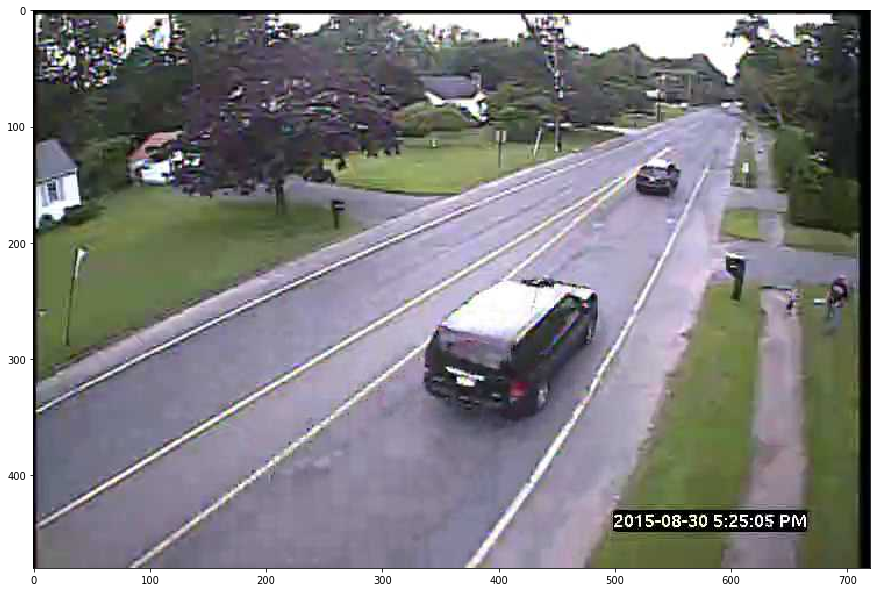

(480, 720, 3)


In [85]:
img = open_image('../assets/dataset/test', data[0]['filename'],True)
print(img.shape)

In [52]:
def draw_image(image, notation):
  fig, ax = plt.subplots(figsize = (15,15))
  ax.imshow(image, interpolation='nearest')
  objs = notation["objects"]
  h = notation["image-size"][0]
  w = notation["image-size"][1]
  for obj in objs:
    plt.text(round(obj["x"]* w), round(obj["y"] * h), obj['class'], backgroundcolor='r', color='w', fontweight='bold')
    rect = patches.Rectangle((round(obj["x"]* w), round(obj["y"] * h)), round(obj["w"] * w), round(obj["h"] * h), linewidth=2, edgecolor='r', facecolor='none') 
    ax.add_patch(rect)
  plt.show()

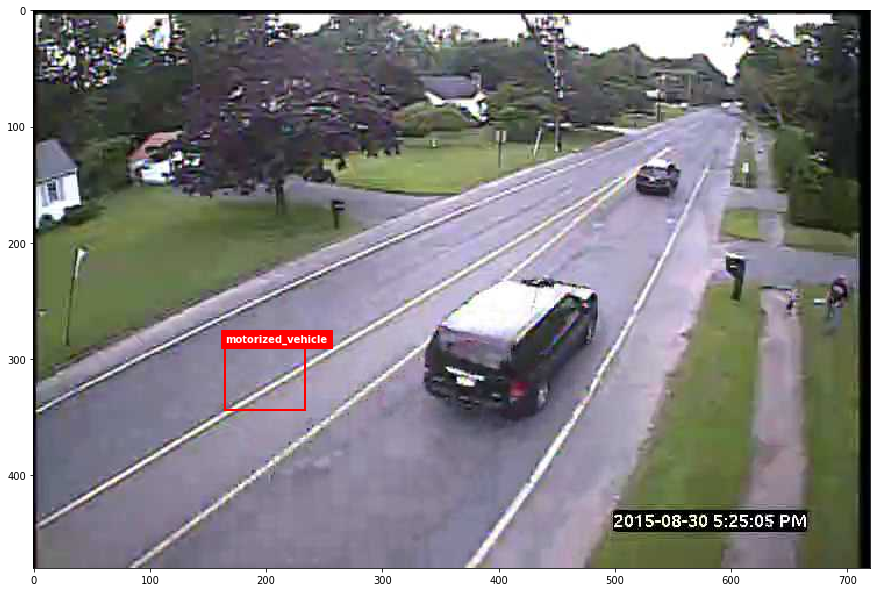

In [86]:
draw_image(img,data[0])

In [42]:
with open('../assets/dataset/train.txt', 'w') as file:
    json.dump(data, file)

TypeError: Object of type DataFrame is not JSON serializable

In [39]:
def get_data(data, image_path, class_name, target_image_shape, max_boxes=100):
    if platform.system() == 'Windows':
        name = data['filename'].replace("/", "\\")
    else:
        name = data['filename']
    filepath = os.path.join(image_path, name)
    img = image.imread(filepath) / 255
    if img.shape != target_image_shape:
        img = tf.image.resize(img, (target_image_shape[0], target_image_shape[1]))
    boxes = np.array([[x['x'], x['y'], x['w'], x['h'], class_name.index(x['class'])] for x in data['objects']])
    boxes_data = np.zeros((max_boxes, 5))

    if len(boxes) > 0:
        np.random.shuffle(boxes)
        boxes = boxes[:max_boxes]
        boxes[:, [0, 2]] = boxes[:, [0, 2]] * target_image_shape[0]
        boxes[:, [1, 3]] = boxes[:, [1, 3]] * target_image_shape[1]
        boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] + boxes[:, 1]

        boxes_data[:len(boxes)] = boxes

    return img, boxes_data

In [40]:
class_name = [line.strip() for line in open('../assets/class_name.txt').readlines()]
print(class_name)
class_name.index('car')

['articulated_truck', 'bicycle', 'bus', 'car', 'motorcycle', 'motorized_vehicle', 'non-motorized_vehicle', 'pedestrian', 'pickup_truck', 'single_unit_truck', 'work_van']


3

In [48]:

img, boxes = get_data(data[5], '../assets/dataset/train',class_name, (460, 460, 3), 100)
print(img.shape)
print(boxes)

(460, 460, 3)
[[ 77.30555556 117.875      118.19444444 155.25         2.        ]
 [  0.         148.54166667  26.19444444 233.83333333   2.        ]
 [258.11111111 126.5        418.47222222 239.58333333   2.        ]
 [146.94444444 126.5        157.80555556 140.875        3.        ]
 [185.91666667 115.         196.13888889 124.58333333   3.        ]
 [128.41666667 122.66666667 137.36111111 132.25         3.        ]
 [  0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.        ]
 [  0.           0.           0.  